# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.decomposition import PCA 
import pprint
from sklearn.cluster import KMeans
import time

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [40]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.shape

(891221, 85)

**The original dataset has 85 columns and 891221 rows**

In [6]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
# grouping by type
feat_info.groupby("type").size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sum()


4896838

In [4]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))

def rep_missing(x, check_list):
    '''
    This Function replace the mising_value with NaNs
    '''
    x_output=x
    for ele in check_list:
        try:
            miss_value = (float(ele))
        except ValueError:
            miss_value = ele
        if x == miss_value:
            x_output = np.nan
            break
    return x_output
    
feat_info['missing_or_unknown']
for featurescolumns in azdias.columns.tolist():
    
    misslist = feat_info[feat_info.attribute==featurescolumns]['missing_or_unknown'].values[0]
    azdias[featurescolumns]=azdias[featurescolumns].apply(lambda x: rep_missing(x, misslist))
azdias_new=azdias.copy()

In [7]:
azdias_new.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_new.isnull().sum()


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

''

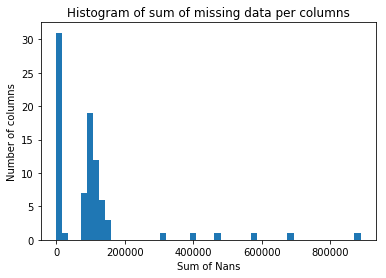

In [43]:
# histogram of the sum of missing values for the columns
plt.hist(azdias_new.isnull().sum(), bins = 50)
plt.title('Histogram of sum of missing data per columns')
plt.ylabel('Number of columns')
plt.xlabel('Sum of Nans')
;

**Based on the histogram, there are definitely outliers - columns that contain more than 200000 missing values are definitely outliers**

In [10]:
azdias_new.isnull().sum().describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

**Looking further into more statistics, the average missing column values is about 98516, with some columns having 0 missing values and at the extreme end, maximum of 889061. Clearly such columns with so many missing values are not useful to me for analysis so will eventually be dropped.**

In [11]:
# Investigate patterns in the amount of missing data in each column.
for i in range(azdias_new.shape[1]):
    if azdias_new.iloc[:, i].isnull().sum() == 889061:
        print(azdias_new.columns[i])


TITEL_KZ


**The column 'TITEl_KZ' had the most missing values of all columns in the dataset**

In [15]:
# columns with no missing values
for i in range(azdias_new.shape[1]):
    if azdias_new.iloc[:, i].isnull().sum() == 0:
        print(azdias_new.columns[i])

ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP


In [5]:
# determing the outliers, cutoff at 200000
outliers = []
for i in range(azdias_new.shape[1]):
    if azdias_new.iloc[:, i].isnull().sum() > 200000:
        outliers.append(azdias_new.columns[i])
print(outliers)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


**The columns; 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' are considered outliers and will be dropped**

In [6]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_new.drop(outliers, axis=1, inplace=True)

In [45]:
# New dataset shape
azdias_new.shape

(891221, 79)

''

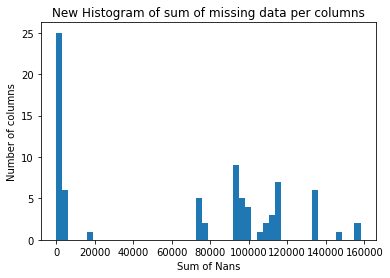

In [30]:
# plot of new histogram after dropping outliers
plt.hist(azdias_new.isnull().sum(), bins = 50)
plt.title('New Histogram of sum of missing data per columns')
plt.ylabel('Number of columns')
plt.xlabel('Sum of Nans')
;

#### Discussion 1.1.2: Assess Missing Data in Each Column
The average missing column values is about 98516, with some columns having 0 missing values and at the extreme end, maximum of 889061 missing value for one column. Most of the columns have 0 missing values and the rest are clustered between 100,000 and 120000, excluding thh outliers(those with more than 200000 missing values).
The following columns were dropped from the dataset based on the cutoff value for missing column values of 200,000:
1. 'AGER_TYP:
2. 'GEBURTSJAHR'
3. 'TITEL_KZ'
4. 'ALTER_HH'
5. 'KK_KUNDENTYP'
6. 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

azdias_new.isnull().sum(axis=1).describe()

count    891221.000000
mean          9.396018
std          13.971829
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          54.000000
dtype: float64

In [46]:
azdias_new.isnull().sum(axis=1).sum()

5035304

In [32]:
azdias_new.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

''

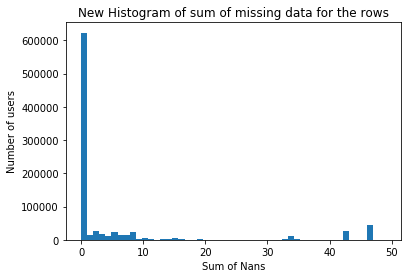

In [47]:
plt.hist(azdias_new.isnull().sum(axis=1), bins = 50)
plt.title('New Histogram of sum of missing data for the rows')
plt.ylabel('Number of users')
plt.xlabel('Sum of Nans')
;

In [7]:
# to sum the missing values across the rows
sum_nans = azdias_new.isnull().sum(axis=1)

In [8]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

above_cut_off = sum_nans[sum_nans > 30]
below_cut_off = sum_nans[sum_nans <=30]  

In [9]:
print('rows missing more than 30 column values:', above_cut_off.shape[0])
print('rows missing less than 30 column values:', below_cut_off.shape[0])

rows missing more than 30 column values: 93154
rows missing less than 30 column values: 798067


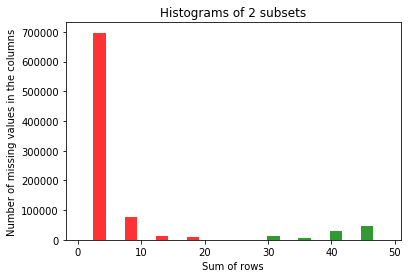

In [51]:
# histogram
plt.hist([above_cut_off, below_cut_off], color=['g', 'r'], alpha=0.8)
plt.title('Histograms of 2 subsets')
plt.ylabel('Number of missing values in the columns')
plt.xlabel('Sum of rows')
plt.show()


In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_compare(column):
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Rows missing more than 30 column values')
    sns.countplot(azdias_new.loc[above_cut_off.index,column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Rows missing less than 30 column values')
    sns.countplot(azdias_new.loc[below_cut_off.index,column]);

    fig.suptitle(column)
    plt.show()

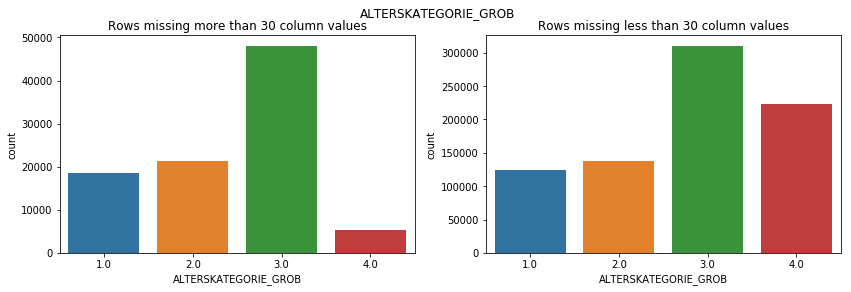

In [12]:
plot_compare('ALTERSKATEGORIE_GROB')

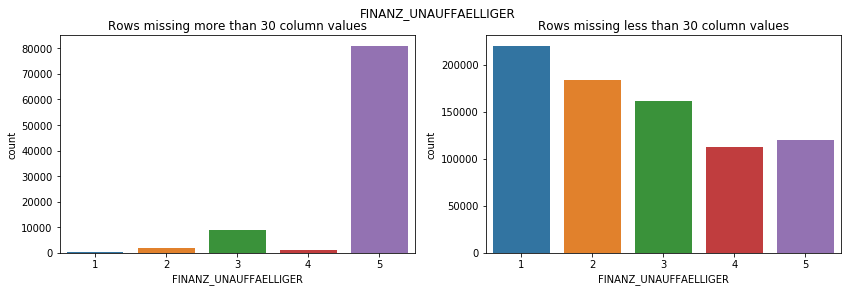

In [54]:
plot_compare('FINANZ_UNAUFFAELLIGER')

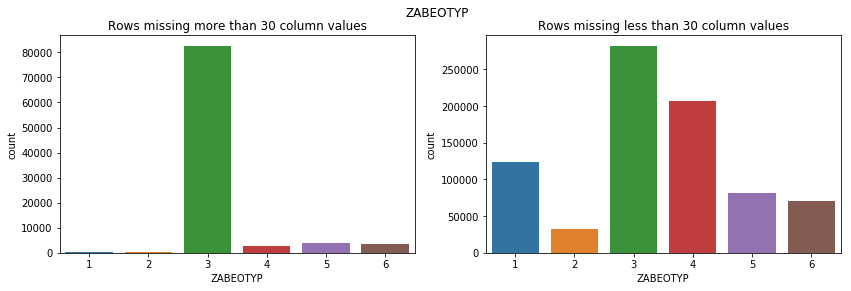

In [55]:
plot_compare('ZABEOTYP')

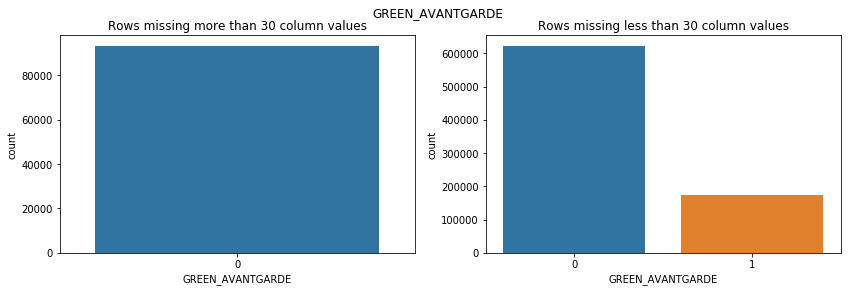

In [56]:
plot_compare('GREEN_AVANTGARDE')

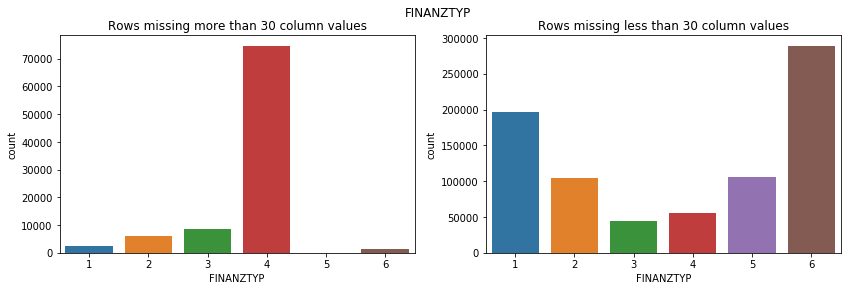

In [13]:
plot_compare('FINANZTYP')

In [10]:
more_missing = azdias_new.iloc[above_cut_off.index]

In [10]:
# drop rows with more than 30 column values
azdias_new = azdias_new[~azdias_new.index.isin(above_cut_off.index)]

In [12]:
azdias_new.shape[0]

798067

#### Discussion 1.1.3: Assess Missing Data in Each Row


Based on the dritribution of missing row values using the histogram, I created 2 groups using 30 as the cutoff value. 
The number of rows missing more than 30 column values were 93154 while rows missing less than 30 column values were 798067.
For plot comparisons, the following observations were made:

1. The column 'ALTERSKATEGORIE_GROB' which is the estimated age based on given name analysis, there were more rows missing 30 values or more compared to rows with less than 30 missing values. Row 3 had substatially more missing values than the rest of the rows. 
2. the column 'FINANZ_UNAUFFAELLIGER' describing the financial typology, there were a lot more rows missing more that 30 values compared to those missing less than 30 values. 
3. the column 'GREEN_AVANTGARDE' describing membership in environmental sustainability had mostly no missing values across the rows. 
4. 'FINANZTYP' column had more rows missing less than 30 column values 

**I decided to drop rows containing more than 30 column values from my dataset for further analysis since the presence of missing values might skew our results and also there is no way of filling the mising values since we dont have access to data collection records. In order to ensure some accuracy in further analysis, it is better to drop the rows.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?

feat_info.groupby("type").size()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [61]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [11]:
# grouping cateogrical variables
cat_columns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
cat_columns

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [12]:
# selecting columns with binary values
binary_cols = []


for i, j in enumerate(cat_columns):
    
    if azdias_new.columns.isin([cat_columns[i]]).sum() > 0:
        
        if len(set(azdias_new[cat_columns[i]].values)) == 2:
            binary_cols.append(cat_columns[i])
        else:
            continue

binary_cols



['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [18]:
for c in binary_cols:
    print(azdias_new[c].value_counts())

2    416181
1    381886
Name: ANREDE_KZ, dtype: int64
0    622842
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791350
1.0      6717
Name: SOHO_KZ, dtype: int64
W    629525
O    168542
Name: OST_WEST_KZ, dtype: int64


In [13]:
# encode the binary columns to 1, 0 codes
azdias_new['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias_new['OST_WEST_KZ'].replace(['W', 'O'], [1,0], inplace=True)


In [72]:
for c in binary_cols:
    print(azdias_new[c].value_counts())

1    416181
0    381886
Name: ANREDE_KZ, dtype: int64
0    622842
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791350
1.0      6717
Name: SOHO_KZ, dtype: int64
1    629525
0    168542
Name: OST_WEST_KZ, dtype: int64


In [14]:
multi_cols = []


for i, j in enumerate(cat_columns):
    
    if azdias_new.columns.isin([cat_columns[i]]).sum() > 0:
        
        if len(set(azdias_new[cat_columns[i]].values)) > 2:
            multi_cols.append(cat_columns[i])
        else:
            continue

multi_cols

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [16]:
for c in multi_cols:
    print(azdias_new[c].value_counts())

4.0    198296
3.0    147220
2.0    141269
5.0    111114
6.0    102108
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
6    289061
1    197172
5    106333
2    104774
4     55924
3     44803
Name: FINANZTYP, dtype: int64
12.0    130261
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57132
3.0      53101
1.0      50659
2.0      43858
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402556
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206853
9.0     136353
10.0    111574
2.0     111118
4.0      73973
3.0      68918
6.0      28896
5.0      27592
8.0      18837
7.0       9204
Name: LP_STATUS_FEIN, dtype: int64
1.0    317971
2.0    170483
4.0    155190
5.0    111574
3.0     38100
Na

In [15]:

# One-hot encoding to create dummy variables for the multi-level columns
azdias_new = pd.get_dummies(azdias_new, columns=multi_cols)

azdias_new.shape

(798067, 195)

In [16]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features


After grouping the columns with binary and multi-level categories, I reencoded 2 of the binary columns to (0, 1) and decided to just create dummy variables for columns with multi-level categories instead of dropping them as they hold a lot of information and may be useful for futher analysis. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [60]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_new[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [16]:
# creating the interval variable for decade
def Pra_decade(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
def pra_move(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1


In [17]:
# binary variable for movement 

azdias_new['Pra_j_dec'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].apply(Pra_decade)
azdias_new['Pra_j_mov'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].apply(pra_move)

In [18]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# ordinal variable for wealth 
cameo_int_wealth_dict = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,\
                      '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,\
                      '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,\
                      '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,\
                      '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 5.0}
azdias_new['cameo_intl_wealth'] = azdias_new['CAMEO_INTL_2015']
azdias_new['cameo_intl_wealth'] = azdias_new['cameo_intl_wealth'].map(cameo_int_wealth_dict)

In [19]:
# ordinal variables for lifestage
cameo_int_ls_dict = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,\
                  '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,\
                  '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,\
                  '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,\
                  '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}
azdias_new['cameo_intl_ls'] = azdias_new['CAMEO_INTL_2015']
azdias_new['cameo_intl_ls'] = azdias_new['cameo_intl_ls'].map(cameo_int_ls_dict)

In [20]:
# dropping the original praegende jugendjahre and cameo_intl columns
azdias_new.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Pra_j_dec,Pra_j_mov,cameo_intl_wealth,cameo_intl_ls
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5.0,4.0
6,2.0,1,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,5.0,1.0,2.0,2.0
7,1.0,0,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,4.0,1.0,1.0,4.0
8,3.0,0,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,5.0,0.0,1.0,3.0
9,3.0,1,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,6.0,0.0,1.0,5.0
10,3.0,1,2,2,5,3,1,5,0,2.0,...,0,0,0,0,1,0,2.0,1.0,5.0,1.0


In [21]:
# drop the cameo_intl_2015 from the dataset
azdias_new.drop(['CAMEO_INTL_2015'], axis=1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Pra_j_dec,Pra_j_mov,cameo_intl_wealth,cameo_intl_ls
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5.0,4.0
6,2.0,1,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,5.0,1.0,2.0,2.0
7,1.0,0,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,4.0,1.0,1.0,4.0
8,3.0,0,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,5.0,0.0,1.0,3.0
9,3.0,1,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,6.0,0.0,1.0,5.0
10,3.0,1,2,2,5,3,1,5,0,2.0,...,0,0,0,0,1,0,2.0,1.0,5.0,1.0


In [22]:
# number or rows and columns in the final dataset
azdias_new.shape

(798067, 199)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I dropped the original 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' variables from the dataset after creating the new variables. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [22]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
  
    def rep_missing(x, check_list):
   
        x_output=x
        for ele in check_list:
            try:
                miss_value = (float(ele))
            except ValueError:
                miss_value = ele
            if x == miss_value:
                x_output = np.nan
                break
        return x_output
    
    feat_info['missing_or_unknown']
    for featurescolumns in azdias.columns.tolist():
    
        misslist = feat_info[feat_info.attribute==featurescolumns]['missing_or_unknown'].values[0]
        df[featurescolumns]=df[featurescolumns].apply(lambda x: rep_missing(x, misslist))
    
    
    
    # remove selected columns and rows, ...
    outliers_list= ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    for col in outliers_list:
        df.drop(col, axis=1, inplace=True)

    
    
    sum_nans = df.isnull().sum(axis=1)
        
   
    above_cut_off = sum_nans[sum_nans > 30]
    
    
    df = df[~df.index.isin(above_cut_off.index)]
    
    # binary and multi-level categorical columns

    # recoding binary variables
    df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1,0], inplace=True)
    
    # multi_level categorical columns



    # One-hot encoding
    df = pd.get_dummies(df, columns=multi_cols)

   
    
    # select, re-encode, and engineer column values.
      # binary variable for movement 
    # creating the interval variable for decade
 


    df['Pra_j_dec'] = df['PRAEGENDE_JUGENDJAHRE'].apply(Pra_decade)
    df['Pra_j_mov'] = df['PRAEGENDE_JUGENDJAHRE'].apply(pra_move)

    df['cameo_intl_wealth'] = df['CAMEO_INTL_2015']
    df['cameo_intl_wealth'] = df['cameo_intl_wealth'].map(cameo_int_wealth_dict)

    df['cameo_intl_ls'] = df['CAMEO_INTL_2015']
    df['cameo_intl_ls'] = df['cameo_intl_ls'].map(cameo_int_ls_dict)
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
            

    
    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [23]:
# applying imputer to replace missing values and feature scaling

imp = Imputer()
imputed_features=imp.fit_transform(azdias_new)

azdias_new_df = pd.DataFrame(imputed_features, columns = azdias_new.columns)

scaler = StandardScaler()
azdias_scaled_arr = scaler.fit_transform(azdias_new_df)

azdias_scaled = pd.DataFrame(azdias_scaled_arr, columns = azdias_new.columns, index = azdias_new.index)

In [33]:

azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Pra_j_dec,Pra_j_mov,cameo_intl_wealth,cameo_intl_ls
1,-1.766066,0.957912,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,-0.530407,1.085949,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,1.165685,0.553151,1.191326,-1.266426
2,0.201243,0.957912,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.885345,1.085949,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,1.165685,-1.875405,-0.865171,0.761985
3,1.184898,0.957912,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.269820,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,-0.232026,0.553151,-1.550669,-0.590289
4,0.201243,-1.043937,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,-0.530407,1.085949,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,-0.232026,0.553151,0.505827,0.085848
5,-1.766066,0.957912,-0.042768,-1.155519,1.138172,-0.570999,-0.470414,1.339319,-0.530407,1.085949,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,-0.089763,-1.629736,0.553151,1.191326,0.761985


### Discussion 2.1: Apply Feature Scaling

I used the imputer to fill in missing values and applied the standard scaler in order to transform the data such that the ditribution has a mean of 0 and standard deviation of 1.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [24]:
# Apply PCA to the data.
pca = PCA(100)

azdias_pca = pca.fit_transform(azdias_scaled)


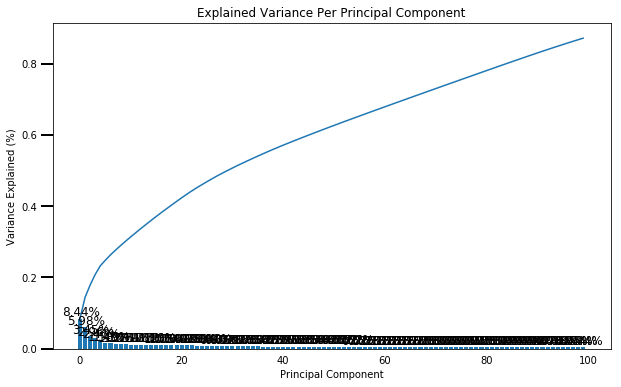

In [25]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)


In [25]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_30 = PCA(n_components  = 30)
azdias_pca_30 = pca_30.fit_transform(azdias_scaled)




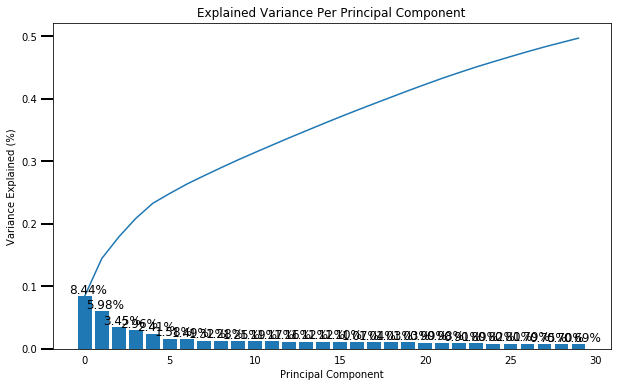

In [27]:
scree_plot(pca_30)

### Discussion 2.2: Perform Dimensionality Reduction

**I selected only 30 transformed features to retain mostly because of the size of the dataset and the amount of time my machine was taking to run for components larger than 30 while processing at the clustering step. At least 50% of the variance is explained by each component.**

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [28]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_features(data, pca, pc_num):
  
    p_comp = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[pc_num]
    p_comp.sort_values(ascending=False, inplace=True)
    p_comp = pd.concat([p_comp.head(5), p_comp.tail(5)])
    
    p_comp.plot(kind='bar', title='Principal Component ' + str(pc_num))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()



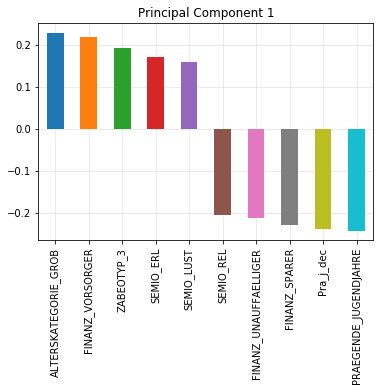

In [29]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight
plot_features(azdias_scaled, pca_30, pc_num=1)

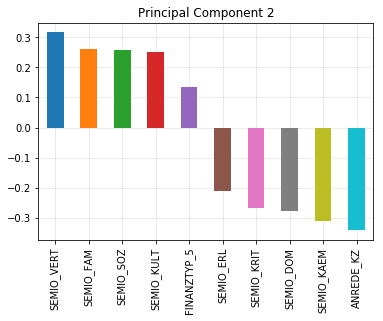

In [31]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_features(azdias_scaled, pca_30, pc_num=2)


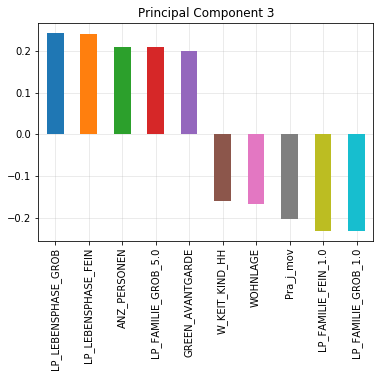

In [30]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_features(azdias_scaled, pca_30, pc_num=3)

### Discussion 2.3: Interpret Principal Components

Interpreting principal components is based on finding out which variables are correlated with each component. For those variables that are positively correlated to a principal component, it means that they vary together in such as if one increases the other variables increase as well. 
**The first pricipal component is postively correlated to:**
1. ALTERSKATEGORIE_GROB - estimated age
2. FINANZ_VORSORGER - individual financial type 'be prepared'
3. ZABEOTYP_3 - energy consumption typology 'smart'
4. SEMIO_ERL - personality typology 'event-oriented'
5. SEMIO_LUST - personality typology 'sensual minded'

**and negatively correlated to:**
1. FINANZ_UNAUFFAELLIGER - individual financial type 'inconspicuous'
2. FINANZ_SPARER - individual financial type 'money savers'
3. PRAEGENDE_JUGENDJAHRE - movement of person's youth
4. Pra_j_dec - movement by decade
5. SEMIO_REL - personality typology 'religious'

Based on these variables as an individual ages, they tend to be more financially prepared, use smart energy consumption options, tend to more event oriented and sensual minded.

**The second  pricipal component is postively correlated to:**
1. SEMIO_VERT - personality typology 'dreamful'
2. SEMIO_FAM - personality typology 'religious'
3. SMIO_SOZ - personality typology 'socially-minded'
4. SEMIO_KULT - personality typology 'cultural-minded'
5. FINANZTYP_5 - individual financial type 'investor'

**and negatively correlated to:**
1. SEMIO_ERL - personality typology 'event-oriented'
2. SEMIO_KRIT - personality typology 'critical-minded'
3. SEMIO_DOM - personality typology 'dominant-minded'
4. SEMIO_KAEM - personality typology 'combative attitude'
5. ANREDE_KZ - gender

The second component is linked mostly to personality types; individuals that are religious, tend to be socially and cultural minded while those that are event oriented are also critical and dominant minded and have a combative attitude. 

**The third pricipal component is postively correlated to:**
1. LP_LEBENSPHASE_GROB - life stage
2. LP_FAMILIE_GROB - family type 
3. LP_LEBENSPHASE_FEIN - life-stage
4. LP_LEBENSPHASE_GROB_5 - single high income earner couples
5. GREEN_AVANTGARDE - membership in environmental sustainability as part of youth

**and negatively correlated to:**
1. Pra_j_move - movement of person's youth
2. LP_FAMILIE_FEIN_1 - family type 'single'
3. LP_FAMILIE_GROB_1 - family type, rough scale 'singel, (maps to 1 in fine scale)'
4. WOHNLAGE - neighborhood quality
5. W_KEIT_KIND_HH - likelihood of children in household

The third principal component contains a mixed array of variables consisting of individual life stages, income levels, family types and neighborhood quality. Based on those variables that are positively correlated to the component, single high income earner couples also tend to have membership in an environmental group. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Text(0.5,1,'SSE vs K')

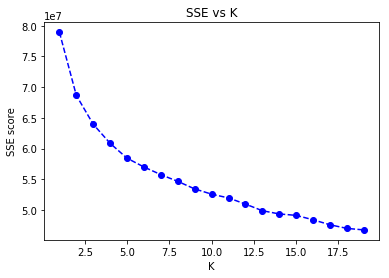

In [25]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
start_time = time.time()    
    # compute the average within-cluster distances.
def fit_kmeans(data, centers):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    
    '''
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    # SSE score for kmeans model 
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,20))
for center in centers:
    scores.append(fit_kmeans(azdias_pca_30, center))
    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot the original data with clusters
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.ylabel('SSE score')
plt.xlabel('K')
plt.title('SSE vs K')


In [26]:

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 10)
new_model = kmeans.fit(azdias_pca_30)
clust_preds = new_model.predict(azdias_pca_30)



### Discussion 3.1: Apply Clustering to General Population
After running the scree plot 
Using the elbow method, I decided to use 10 clusters to use for the predictions. This is where the graph seems to be levelling and there was not much of an effect after the 10th cluster.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [27]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [28]:
customers.shape

(191652, 85)

In [28]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_clean.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(141725, 198)

In [35]:
# display the first 5 columns of the customers data 
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Pra_j_dec,Pra_j_mov,cameo_intl_wealth,cameo_intl_ls
0,4.0,0,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,2.0,0.0,1.0,3.0
2,4.0,1,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,2.0,0.0,3.0,4.0
3,4.0,0,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1.0,1.0,2.0,4.0
4,3.0,0,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,1.0
5,3.0,0,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,2.0,0.0,3.0,4.0


In [36]:
# compare the column list of the azdias and customer data 
list(set(azdias_new.columns) - set(customers_clean))

['GEBAEUDETYP_5.0']

In [29]:
# add the missing column to the customers data and label it 0 
customers_clean['GEBAEUDETYP_5.0'] = 0


In [43]:
customers_clean.shape

(141725, 199)

In [30]:
# applying the imputer in the customers data
customers_clean_imp=imp.transform(customers_clean)

In [31]:
# applying deature scaling 

customers_clean_df = pd.DataFrame(customers_clean_imp, columns = customers_clean.columns)

customers_scaled_arr = scaler.transform(customers_clean_df)

customers_scaled = pd.DataFrame(customers_scaled_arr, columns = customers_clean.columns, index = customers_clean.index)



In [48]:
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Pra_j_dec,Pra_j_mov,cameo_intl_wealth,cameo_intl_ls,GEBAEUDETYP_5.0
0,1.184898,-1.043937,1.409058,-1.155519,1.138172,-1.249987,-0.470414,-0.791197,1.885345,-1.625588,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,22.370561,-3.027447,0.553151,-0.179672,-1.942562
2,1.184898,0.957912,1.409058,-1.155519,1.138172,-1.249987,0.958633,0.629147,1.885345,-0.269820,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,22.370561,-3.027447,5.410263,0.505827,-1.942562
3,1.184898,-1.043937,1.409058,-1.155519,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.269820,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,11.140399,-2.328591,2.981707,0.505827,-1.942562
4,0.201243,-1.043937,-0.042768,-1.155519,0.411886,0.786977,1.673157,-0.791197,-0.530407,1.085949,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,44.830885,-2.328591,7.838819,-1.550669,-1.942562
5,0.201243,-1.043937,1.409058,-1.155519,1.138172,-1.249987,-0.470414,-0.081025,1.885345,1.085949,...,-0.150064,-0.162541,-0.189538,-0.179781,-0.192767,22.370561,-3.027447,5.410263,0.505827,-1.942562


In [32]:
#transform the customers using pca
customers_pca = pca_30.transform(customers_scaled)
#predict clustering using the kmeans
predict_customers = new_model.predict(customers_pca)

In [42]:
centers = new_model.cluster_centers_

In [43]:
centers.shape

(10, 30)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

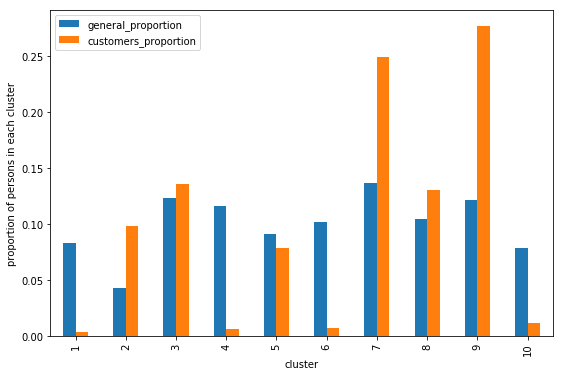

In [33]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_pop = []
x = [i+1 for i in range(10)]
for i in range(10):
    general_pop.append((clust_preds == i).sum()/len(clust_preds))
    customers_pop.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'general_proportion' : general_pop, 'customers_proportion':customers_pop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()


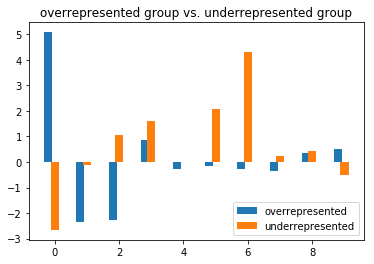

In [46]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Centers_pl = np.arange(0,10)

ax1 = plt.subplot(111)
ax1.bar(Centers_pl - 0.2,centers[3][0:10], width = 0.25)
ax1.bar(Centers_pl,centers[1][0:10], width = 0.25)
ax1.set_title('overrepresented group vs. underrepresented group')
plt.legend(['overrepresented','underrepresented'])
plt.show()

In [50]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centers_inverse = scaler.inverse_transform(pca_30.inverse_transform(centers))
centers_df = pd.DataFrame(centers_inverse, columns = azdias_scaled.columns)
overrepresented = centers_df.loc[9]
underrepresented = centers_df.loc[1]



In [72]:
# interested variables for comparison 
interested_variables = [ 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_SPARER', 'FINANZ_HAUSBAUER','FINANZ_MINIMALIST' ]

In [73]:

print("Feature.......Overrepresented.......Underrepresented")
for x in interested_variables:
    print(f"{x}.......{overrepresented[x]}.......{underrepresented[x]}")

Feature.......Overrepresented.......Underrepresented
FINANZ_VORSORGER.......2.27256393190625.......3.688309085675
FINANZ_ANLEGER.......3.6149284938039563.......2.639048170057594
FINANZ_SPARER.......3.846970585337684.......2.2761945278397513
FINANZ_HAUSBAUER.......1.9692156304901345.......2.5604874194467517
FINANZ_MINIMALIST.......3.323625582869341.......3.825471502663066


### Discussion 3.3: Compare Customer Data to Demographics Data

**For my feature analysis comparing those underrepresented and overrepresented in cluster 1 and 9, I was interested in individual financial types thus included 6 variables in my analysis:**
1. 'FINANZ_VORSORGER' (individual financial type for those that are prepared)
2. 'FINANZ_ANLEGER'(individual financial type for Investors)
3. 'LP_LEBENSPHASE_FEIN'(life stage)
4. 'FINANZ_HAUSBAUER'(individual financial type for house owners)
5. 'FINANZ_MINIMALIST' (those with low financial interest)
6. 'FINANZ_SPARER' (money-savers)


**The cluster that had overrepresented customer data, consisted of individuals that are more likely to be investors and more likely to be money savers.**

**Those in the underrepresented cluster are more likely to own homes, have low financial interest and are more likely to be prepared.** 

**Using this analysis based on the different clusters and the characteristics of individuals in these clusters, Bertelsmann Arvato Analytics can target specific segments of the population for their marketing campaigns that will yield the highest expected rate of returns.** 

## References
1. https://github.com/bdfaus/Identify_Customer_Segments
2. https://github.com/MiguelAMartinez/identify-customer-segments-Arvato/blob/master/Identify_Customer_Segments.ipynb
3. How to plot two histograms at the same time. https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
4. https://github.com/atahmasb/Identify-Customer-Segments-with-Arvato/blob/master/Identify_Customer_Segments.ipynb
5. How to use scikit-learn fit transform with pandas. https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
6. Interpretation of teh Principal Components. https://newonlinecourses.science.psu.edu/stat505/node/54/

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.